# Preprocessing

## Featurizing

In [1]:
import mdtraj as md
import numpy as np
import datetime
import tensorflow as tf
import nglview as nv

%cd /home/jovyan/ASMSA/mydev

import os, sys

repo_dir = os.getcwd()   
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)

from src.utils import plot_latent_space
from src.asmsa_callbacks import callbacks
from src.vae import asmsa_beta_vae
from src.asmsa_features import process_trajectory
from src.asmsa_split import  split_dataset

nn_model = 'vae'
latent_dim = 2

2025-08-15 08:01:22.398625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-15 08:01:22.412148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-15 08:01:22.416102: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-15 08:01:22.425996: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-15 08:01:23.042617: W tensorflow/compiler/tf2

[Errno 2] No such file or directory: '/home/jovyan/ASMSA/mydev'
/home/tedeschg/prj/ASMSA/mydev


In [2]:
tr = "trpcage_ds_nH.xtc"
conf = "trpcage_npt400_nH.pdb"

traj = md.load_xtc(tr, top=conf)
backbone_atoms = traj.topology.select('backbone')
traj.superpose(traj, 0, atom_indices=backbone_atoms)

<mdtraj.Trajectory with 50001 frames, 144 atoms, 20 residues, and unitcells at 0x7614f16d75b0>

In [3]:
view = nv.show_mdtraj(traj)

view.add_representation('line', selection='protein')
view

NGLWidget(max_frame=50000)

In [4]:
feat = process_trajectory(tr, conf)

## NN preprocessing

In [5]:
# Uso:
ds_train, ds_val, ds_test, ds_all, info = split_dataset(feat['features_normalized'], train_size=70, val_size=15, batch_size=64, seed=42)

I0000 00:00:1755237687.005264  469742 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1755237687.025339  469742 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1755237687.025527  469742 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1755237687.026353  469742 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Dataset Split Statistics:
  Total samples: 50001
  Train: 35000 samples (70.0%), 546 batches
  Val:   7500 samples (15.0%), 118 batches
  Test:  7501 samples (15.0%), 118 batches
  Batch size: 64
  Features shape: (50001, 558)
  Seed: 42


# VAE

In [6]:
log_dir = "logs/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

cb = callbacks(log_dir, latent_dim, monitor="val_loss", model=nn_model)

beta_vae, encoder, decoder = asmsa_beta_vae(
    n_features=feat['features_normalized'].shape[1], 
    latent_dim=latent_dim,
    beta=1e-4,
    )

try:
    beta_vae.cov_reg.assign(7e-4)
except AttributeError:
    beta_vae.cov_reg = 7e-4

In [7]:
beta_vae.fit(ds_train, epochs=500, validation_data=ds_val, callbacks=cb)

Epoch 1/500


I0000 00:00:1755237692.627149  469791 service.cc:146] XLA service 0x7613fc002bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755237692.627169  469791 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-15 08:01:32.736297: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-15 08:01:33.356341: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 15/546 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - beta: 1.0000e-04 - cov_reg_weight: 7.0000e-04 - kl_loss: 1.4263e-04 - kl_loss_unweighted: 1.4263 - loss: 0.3915 - reconstruction_loss: 0.3911 - whiten_reg: 2.4924e-04    

I0000 00:00:1755237697.850194  469791 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


545/546 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - beta: 1.0000e-04 - cov_reg_weight: 7.0000e-04 - kl_loss: 1.6861e-04 - kl_loss_unweighted: 1.6861 - loss: 0.2747 - reconstruction_loss: 0.2743 - whiten_reg: 2.5918e-04
Epoch 1: val_loss improved from inf to 0.14859, saving model to vae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - beta: 1.0000e-04 - cov_reg_weight: 7.0000e-04 - kl_loss: 1.6876e-04 - kl_loss_unweighted: 1.6876 - loss: 0.2745 - reconstruction_loss: 0.2741 - whiten_reg: 2.5957e-04 - val_beta: 1.0000e-04 - val_cov_reg_weight: 7.0000e-04 - val_kl_loss: 2.8906e-04 - val_kl_loss_unweighted: 2.8906 - val_loss: 0.1486 - val_reconstruction_loss: 0.1475 - val_whiten_reg: 7.7493e-04 - learning_rate: 1.0000e-04
Epoch 2/500
 35/546 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - beta: 1.0000e-04 - cov_reg_weight: 7.0000e-04 - kl_loss: 3.0579e-04 - kl_loss_unweighted: 3.0579 - loss: 0.1680 - reconstruction_loss: 0.1669 - whiten_reg: 8.1433e-04

/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


534/546 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - beta: 1.0000e-04 - cov_reg_weight: 7.0000e-04 - kl_loss: 3.2548e-04 - kl_loss_unweighted: 3.2548 - loss: 0.1630 - reconstruction_loss: 0.1617 - whiten_reg: 9.5160e-04
Epoch 2: val_loss improved from 0.14859 to 0.13984, saving model to vae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - beta: 1.0000e-04 - cov_reg_weight: 7.0000e-04 - kl_loss: 3.2579e-04 - kl_loss_unweighted: 3.2579 - loss: 0.1629 - reconstruction_loss: 0.1616 - whiten_reg: 9.5354e-04 - val_beta: 1.0000e-04 - val_cov_reg_weight: 7.0000e-04 - val_kl_loss: 3.4751e-04 - val_kl_loss_unweighted: 3.4751 - val_loss: 0.1398 - val_reconstruction_loss: 0.1383 - val_whiten_reg: 0.0012 - learning_rate: 1.0000e-04
Epoch 3/500
542/546 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - beta: 1.0000e-04 - cov_reg_weight: 7.0000e-04 - kl_loss: 3.5245e-04 - kl_loss_unweighted: 3.5245 - loss: 0.1504 - reconstruction_loss: 0.1491 - whiten_reg: 0.0010
Epoch 3: val_loss improved from 0.13984 to 0.13646, saving m

In [8]:
src = f"vae_{latent_dim}d.keras"
dest = "/home/tedeschg/prj/ASMSA/mydev/models/"

!mv {src} {dest}

In [9]:
print("cov_reg =", float(beta_vae.cov_reg.numpy()))


cov_reg = 0.000699999975040555


tensorboard --logdir logs/autoencoder --host localhost --port 6006

# Decode and visualize

In [10]:
encoder.save('./models/encoder_vae.keras')
decoder.save('./models/decoder_vae.keras')


In [11]:
for batch_x, _ in ds_test.take(1):
    sample_x = batch_x[30]  
    break
    
sample_x_batch = tf.expand_dims(sample_x, axis=0)
z_mean, z_log_var, test = encoder.predict(sample_x_batch)

z_mean

2025-08-15 08:04:03.612790: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


array([[-1.2404658,  1.7026544]], dtype=float32)

In [31]:

# BetaVAE latent-space & decoding report
# - Prende un campione dal validation set
# - Calcola: z_mean stats, KL unweighted per sample, reconstruction errors
# - Trustworthiness a k={5,10,20}
# - Salva un PDF con i principali plot
# - Stampa un riepilogo numerico

import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from asmsa_pdf_report import *

import asmsa_pdf_report 

asmsa_pdf_report.primary_color = '#2E86C1'
asmsa_pdf_report.secondary_color = '#E74C3C'
asmsa_pdf_report.accent_color  = '#F39C12'
asmsa_pdf_report.bg_color      = '#F8F9FA'

# ------------------ Prendi i dati e calcola ------------------
# Usa gli oggetti già presenti nella tua sessione: beta_vae, ds_val
model = beta_vae
X_val = take_from_dataset(ds_val, max_samples=8000).numpy().astype(np.float32)
z_mean, z_log_var, z_samp, X_hat = run_encoder_decoder(model, X_val, batch_size=64)
latent_dim = z_mean.shape[1]

kl_ps   = kl_per_sample(z_mean, z_log_var)
mse_ps, mae_ps, combo_ps = recon_errors(X_val, X_hat)

mu_mean = z_mean.mean(axis=0)
mu_cov  = np.cov(z_mean, rowvar=False)
mu_var  = np.diag(mu_cov)
mu_corr, off_diag = corr_offdiag(mu_cov)

tw_k = {}
for k in (5, 10, 20):
    try:
        tw_k[k] = safe_trustworthiness(X_val, z_mean, k)
    except Exception:
        tw_k[k] = np.nan

recon_mse = float(np.mean(mse_ps))
recon_mae = float(np.mean(mae_ps))
recon_combo = float(np.mean(combo_ps))
kl_mean = float(np.mean(kl_ps))

try:
    beta_val = float(model.beta.numpy())
except Exception:
    beta_val = None
try:
    cov_reg_val = float(model.cov_reg.numpy() if hasattr(model.cov_reg, "numpy") else model.cov_reg)
except Exception:
    cov_reg_val = None

# ------------------ PDF Report Migliorato ------------------

# Configurazione stile per tutto il report
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.titlesize'] = 14

report_path = "beta_vae_latent_report_enhanced.pdf"

# Funzione principale per generare il report
with PdfPages(report_path) as pdf:
    create_summary_page(pdf, X_val, latent_dim, beta_val, cov_reg_val,
                       kl_mean, kl_ps, recon_mse, recon_mae, recon_combo,
                       mu_mean, mu_var, off_diag, tw_k)
    
    # Pagina 2: Visualizzazione spazio latente
    create_latent_scatter(pdf, z_mean, combo_ps, latent_dim)
    
    # Pagina 3: Analisi dimensioni
    create_dimension_analysis(pdf, z_mean, latent_dim)
    
    # Pagina 4: Analisi correlazioni
    create_correlation_analysis(pdf, mu_corr, latent_dim)
    
    # Pagina 5: Dashboard metriche
    create_metrics_dashboard(pdf, combo_ps, kl_ps, tw_k)

print("✅ Report migliorato salvato:", os.path.abspath(report_path))
print("\n📊 RIEPILOGO FINALE:")
print("=" * 50)
print(f"🔥 KL divergence:      {kl_mean:.4f} ± {np.std(kl_ps):.4f}")
print(f"🔧 Reconstruction:     MSE={recon_mse:.6f}, MAE={recon_mae:.6f}")
print(f"📈 Combined metric:    {recon_combo:.6f}")
print(f"🎯 Latent statistics:  μ_avg={np.mean(mu_mean):.3f}, σ_avg={np.mean(np.sqrt(mu_var)):.3f}")
print(f"🔗 Avg |correlation|:  {np.nanmean(np.abs(off_diag)):.4f}")
print(f"✅ Trustworthiness:    {dict(sorted({k: round(tw_k[k], 4) for k in tw_k}.items()))}")
print("=" * 50)


/home/tedeschg/prj/ASMSA/mydev/asmsa_pdf_report.py:154: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  pdf.savefig(fig, bbox_inches='tight', facecolor='white')
/home/tedeschg/prj/ASMSA/mydev/asmsa_pdf_report.py:154: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  pdf.savefig(fig, bbox_inches='tight', facecolor='white')
/home/tedeschg/prj/ASMSA/mydev/asmsa_pdf_report.py:154: UserWarning: Glyph 128295 (\N{WRENCH}) missing from current font.
  pdf.savefig(fig, bbox_inches='tight', facecolor='white')
/home/tedeschg/prj/ASMSA/mydev/asmsa_pdf_report.py:154: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  pdf.savefig(fig, bbox_inches='tight', facecolor='white')
/home/tedeschg/prj/ASMSA/mydev/asmsa_pdf_report.py:154: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  pdf.savefig(fig, bbox_inches='tight', facecolor='white')
/home/tedeschg/prj/ASMSA/mydev/asmsa_pdf_report.py:154: UserWarning: Glyph 1

✅ Report migliorato salvato: /home/tedeschg/prj/ASMSA/mydev/beta_vae_latent_report_enhanced.pdf

📊 RIEPILOGO FINALE:
🔥 KL divergence:      6.4888 ± 1.0388
🔧 Reconstruction:     MSE=0.100575, MAE=0.217236
📈 Combined metric:    0.123907
🎯 Latent statistics:  μ_avg=-0.055, σ_avg=1.025
🔗 Avg |correlation|:  0.0246
✅ Trustworthiness:    {5: 0.8015, 10: 0.8013, 20: 0.8007}


782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


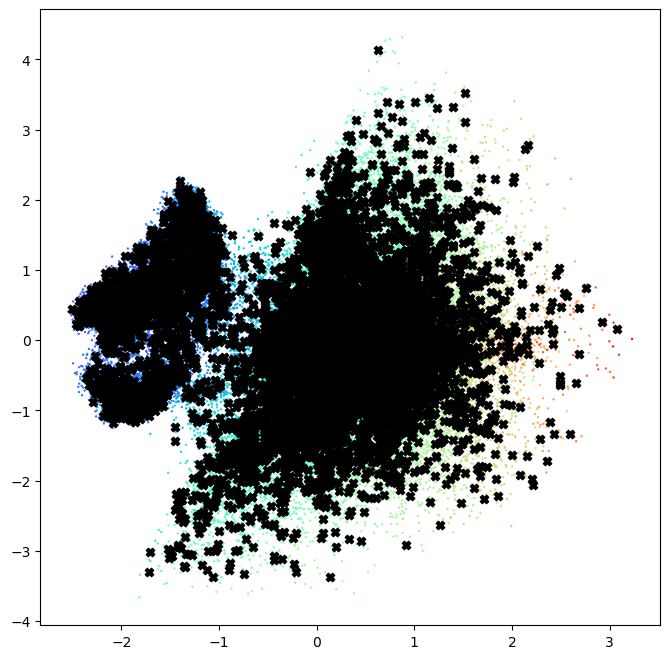

In [13]:
target = np.array([0,-2]).reshape(1, latent_dim)
bb_indices = traj.topology.select('backbone')
ca_indices = traj.topology.select('name CA')
emb, sample = plot_latent_space(latent_dim, encoder, ds_all, conf, tr, z_mean, bb_indices, model=nn_model, exact=False)

In [14]:
rms_ref = md.load_pdb(conf)
rms_ref_bb  = rms_ref.atom_slice(bb_indices)
rms_ref_ca  = rms_ref.atom_slice(ca_indices)
rms_tr = md.load_xtc(tr, top=rms_ref)
rmsd = md.rmsd(rms_tr, rms_ref)

In [15]:
p_indices = traj.topology.select("protein")
n_p = len(p_indices)

In [16]:
s = decoder.predict(sample)

coords_size = feat['coords'].shape[1]  # dimensione delle coordinate
angles_size = s.shape[1] - coords_size  # dimensione degli angoli

# Separa coordinate e angoli
s_coords = s[:, :coords_size]
s_angles = s[:, coords_size:]

# Inverti le trasformazioni separatamente
coords_orig = feat['scaler_coords'].inverse_transform(s_coords)
angles_orig = feat['scaler_angles'].inverse_transform(s_angles)

# Prendi solo le coordinate per la ricostruzione
coords_flat = coords_orig[0, :]                    
coords_p = coords_flat.reshape((n_p, 3))
mask_bb = np.isin(p_indices, bb_indices)
coords_bb = coords_p[mask_bb] 
coords_ca = coords_bb[1::4] 

new_traj = md.Trajectory(
    xyz=np.array([coords_bb]),     
    topology=rms_ref_bb.topology     
)
new_traj.save_pdb("./models/vae_reconstructed.pdb")

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [17]:
view = nv.show_file('./models/vae_reconstructed.pdb')
view.clear_representations()
view.add_line() 
#view.add_cartoon()
view.center()
view

NGLWidget()

In [18]:
mse = np.mean((s[0] - sample_x.numpy())**2)
print("MSE ricostruzione:", mse)

MSE ricostruzione: 0.17164488


/home/tedeschg/prj/ASMSA/mydev/src/asmsa_analysis.py:117: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  plt.tight_layout()
/home/tedeschg/prj/ASMSA/mydev/src/asmsa_analysis.py:117: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/home/tedeschg/prj/ASMSA/mydev/src/asmsa_analysis.py:117: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152

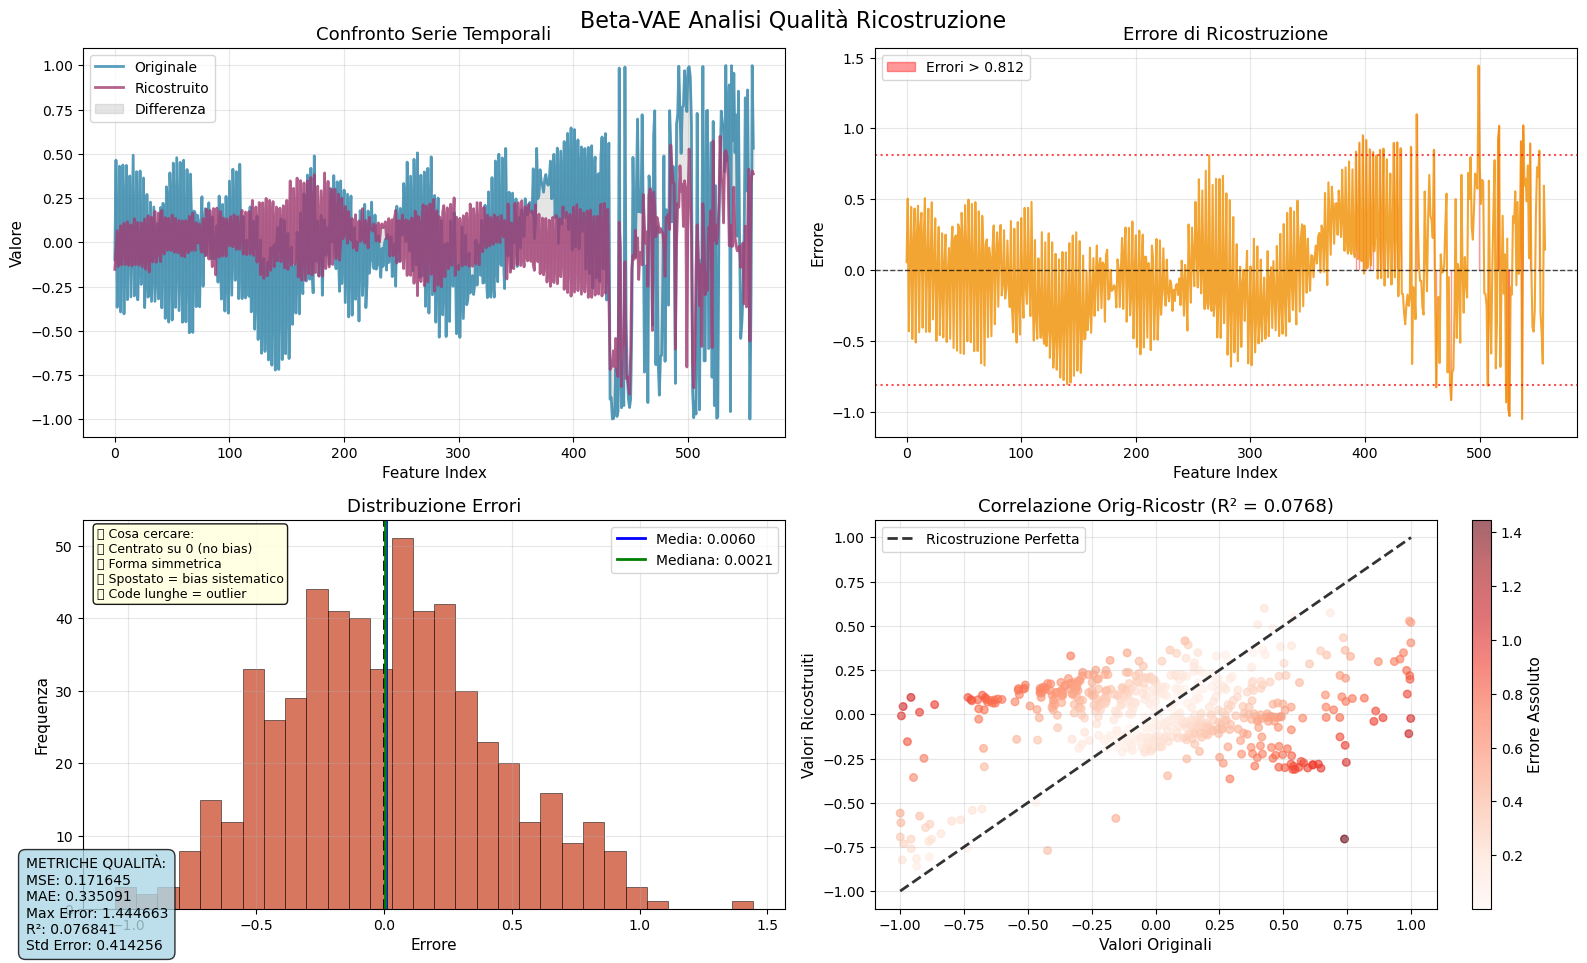

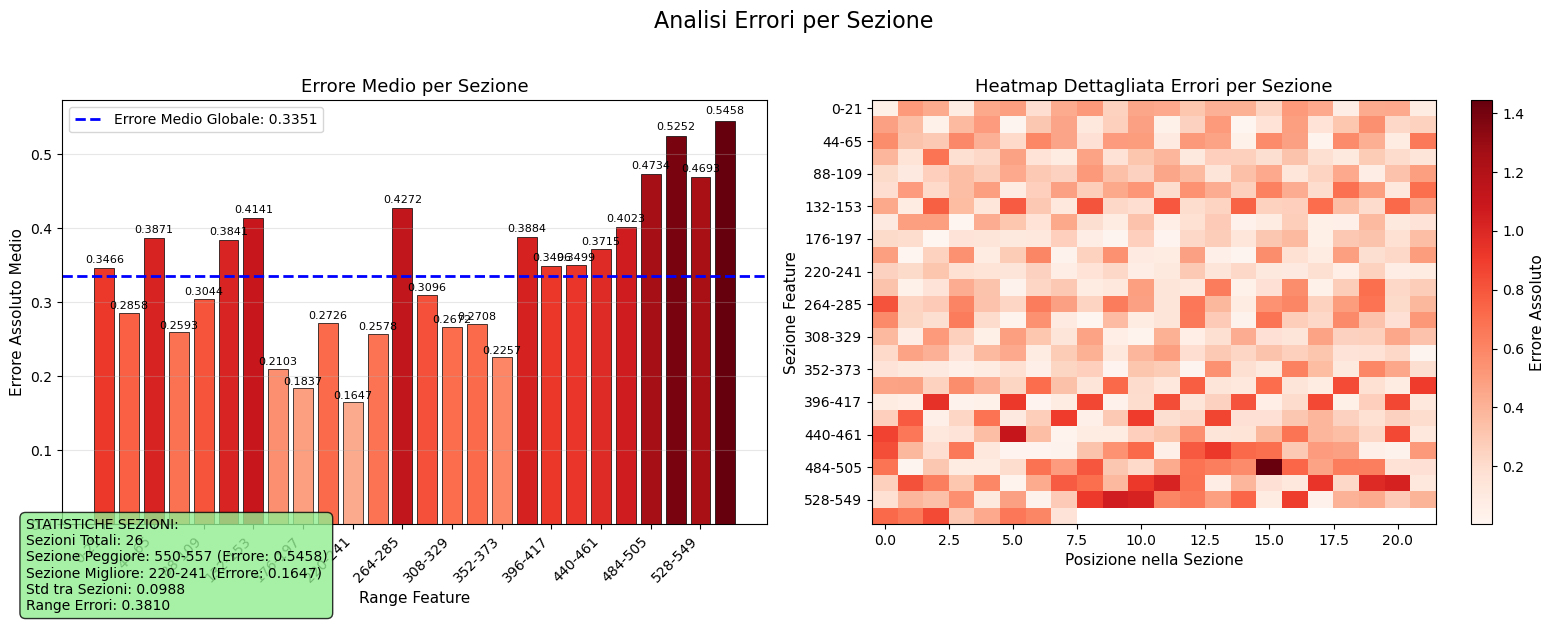


=== METRICHE RICOSTRUZIONE ===


In [19]:
from src.asmsa_analysis import analyze_reconstruction, plot_section_errors
import matplotlib.pyplot as plt
# Utilizzo con i tuoi dati
# Assumendo che sample_x e s[0] siano definiti
orig = sample_x.numpy() 
recon = s[0]

# Analisi completa
fig, metrics = analyze_reconstruction(orig, recon, title_prefix="Beta-VAE ")

# Solo errori per sezione
fig_sections, section_stats = plot_section_errors(orig, recon, n_sections=25, 
                                                   title="Analisi Errori per Sezione")

plt.show()

# Stampa metriche
print("\n=== METRICHE RICOSTRUZIONE ===")
for metric, value in metrics.items():
    (f"{metric.upper()}: {value:.6f}")

In [20]:
import nglview as nv

# Crea un widget vuoto
view = nv.NGLWidget()

# --- primo modello -------------------------------------------------
comp1 = view.add_component("./models/vae_reconstructed.pdb")   # oppure percorso al tuo 1° PDB
comp1.clear_representations()                         # opzionale
comp1.add_representation("line", color="skyblue")  # o 'line', 'surface', ecc.

# --- secondo modello ----------------------------------------------
comp2 = view.add_component("./models/ae_reconstructed.pdb")       # secondo PDB da sovrapporre
comp2.clear_representations()
comp2.add_representation("line", color="orange")   # scegli un colore diverso

# Centra e mostra
view.center()
view


NGLWidget()